In [1]:
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss
from tools.simulation import setup_event_simulator
from tools.optimization import get_initial_guess

import jax
import jax.numpy as jnp
import time

from jax import jit

# uncomment to run on CPU
# jax.config.update('jax_platform_name', 'cpu')

ImportError: cannot import name 'compute_loss' from 'tools.losses' (/home/oalterka/desktop_linux/diffWC/diffCherenkov/tools/losses.py)

In [26]:
default_json_filename = 'config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000

# Set data temperature as None for no smoothing
temperature = None 

# Temperature for simulation
temperature_sim = 0.5

In [27]:
simulate_true_data = setup_event_simulator(default_json_filename, Nphot, temperature, is_data=True)
simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature_sim)

In [10]:
# Generate and save a single event
key = jax.random.PRNGKey(719500)

# Sample true parameter configurations:

# cone on the wall
true_params = (
    jnp.array(30.0),  # opening angle
    jnp.array([0.5, 0.0, -0.5]),  # position
    jnp.array([1.0, -1.0, 0.2]),  # direction
    jnp.array(5000.0)  # intensity
)

# fully open cone along the wall
true_params = (
    jnp.array(90.0),  # opening angle
    jnp.array([0.0, 0.0, 0.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5000.0)  # intensity
)

# Generate random parameters
true_params = generate_random_params(key)

single_event_data = simulate_event(true_params, key)

save_single_event(single_event_data, true_params, filename='events/test_event_data.h5')

'events/test_event_data.h5'

Event Parameters:
────────────────────
Opening Angle: 28.96 degrees
Initial Position: (0.12, 0.84, -0.04)
Initial Direction: (1.33, -1.14, 0.96)
Initial Intensity: 5.51
────────────────────


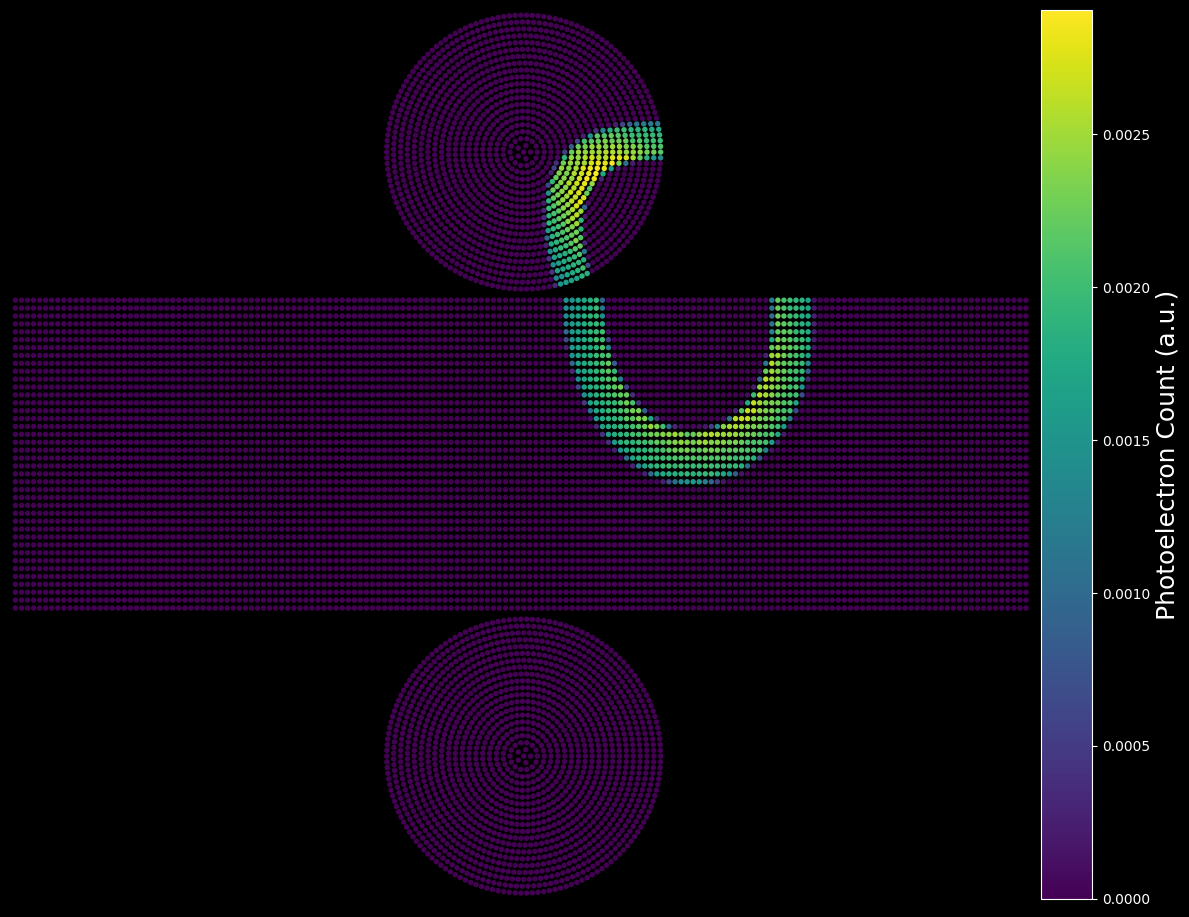

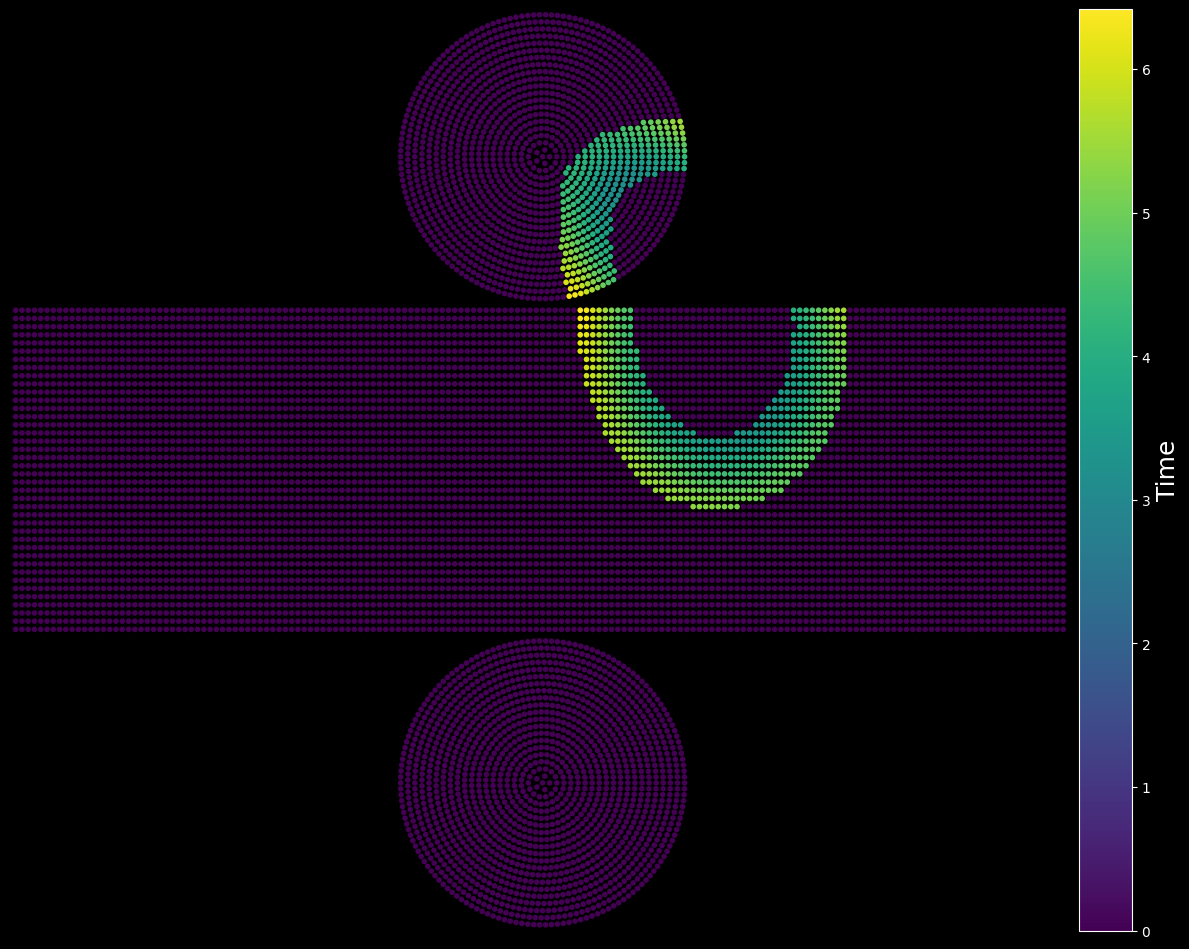

In [11]:
from tools.visualization import create_detector_display
event_location = 'events/test_event_data.h5'
loaded_params, loaded_indices, loaded_charges, loaded_times = load_single_event(event_location, NUM_DETECTORS)
print_params(loaded_params)

detector_display = create_detector_display()
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=True)

Event Parameters:
────────────────────
Opening Angle: 28.96 degrees
Initial Position: (0.12, 0.84, -0.04)
Initial Direction: (1.33, -1.14, 0.96)
Initial Intensity: 5.51
────────────────────
Event Parameters:
────────────────────
Opening Angle: 34.82 degrees
Initial Position: (-0.06, -0.30, 0.72)
Initial Direction: (0.86, -0.37, 0.36)
Initial Intensity: 6.47
────────────────────


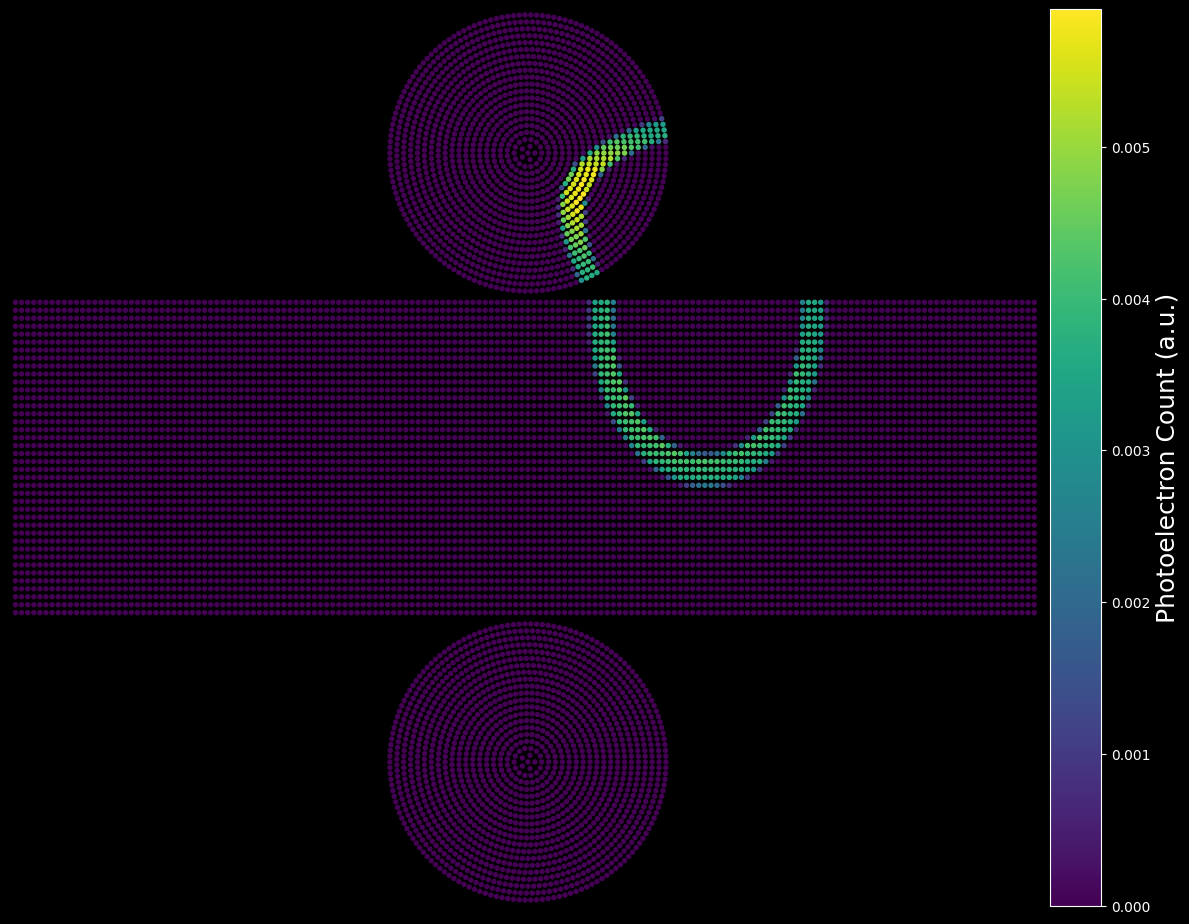

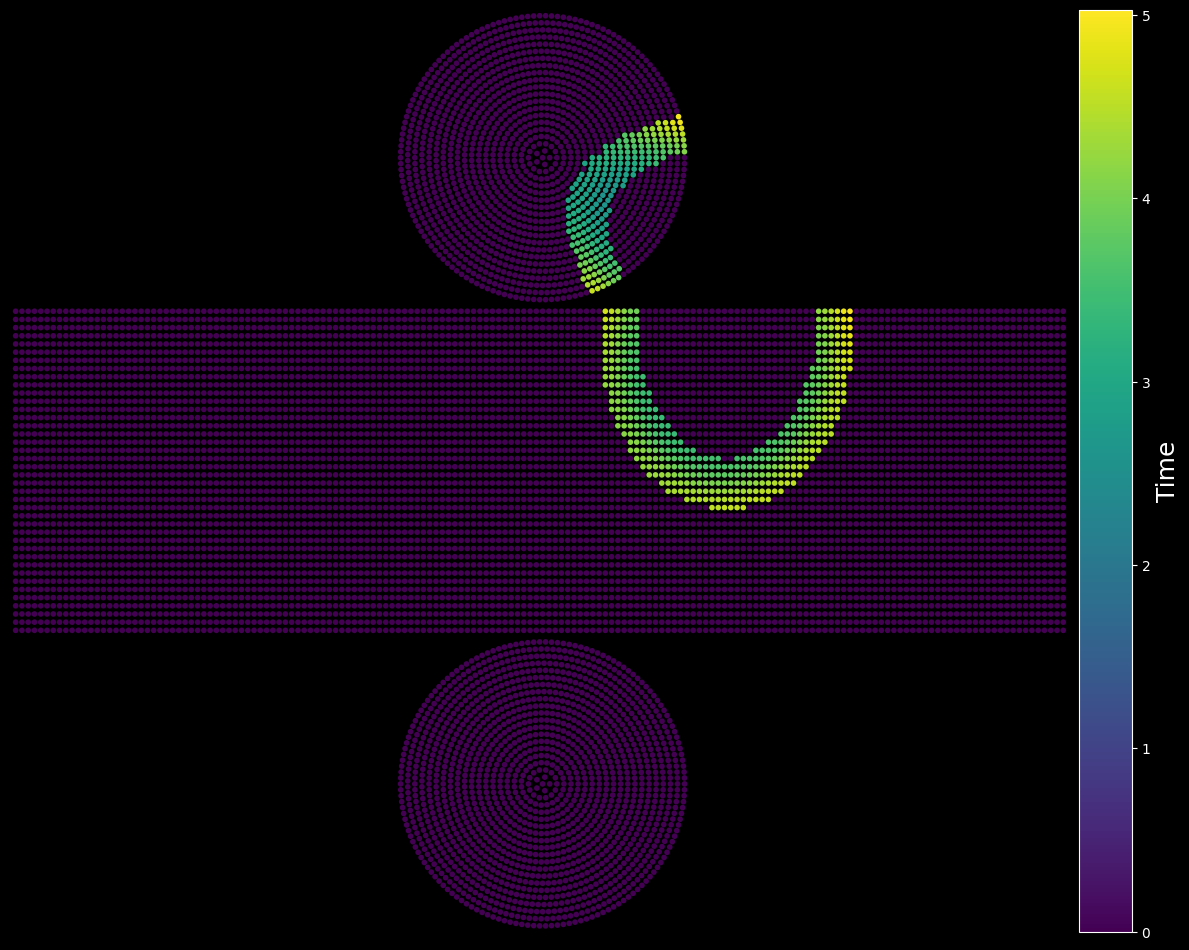

In [12]:
from tools.visualization import create_detector_display

event_location = 'events/test_event_data.h5'
loaded_params, loaded_charges, loaded_times = load_single_event(event_location, NUM_DETECTORS, sparse=False)
print_params(loaded_params)

guess = get_initial_guess(loaded_charges, detector_points, key=key)
print_params(guess)

# simulate event with guess
charges, times = simulate_event(guess, key)

# plot guess
detector_display = create_detector_display(sparse=False)
detector_display(charges, times, file_name='event_display.png', plot_time=False)
detector_display(charges, times, file_name='event_display.png', plot_time=True)

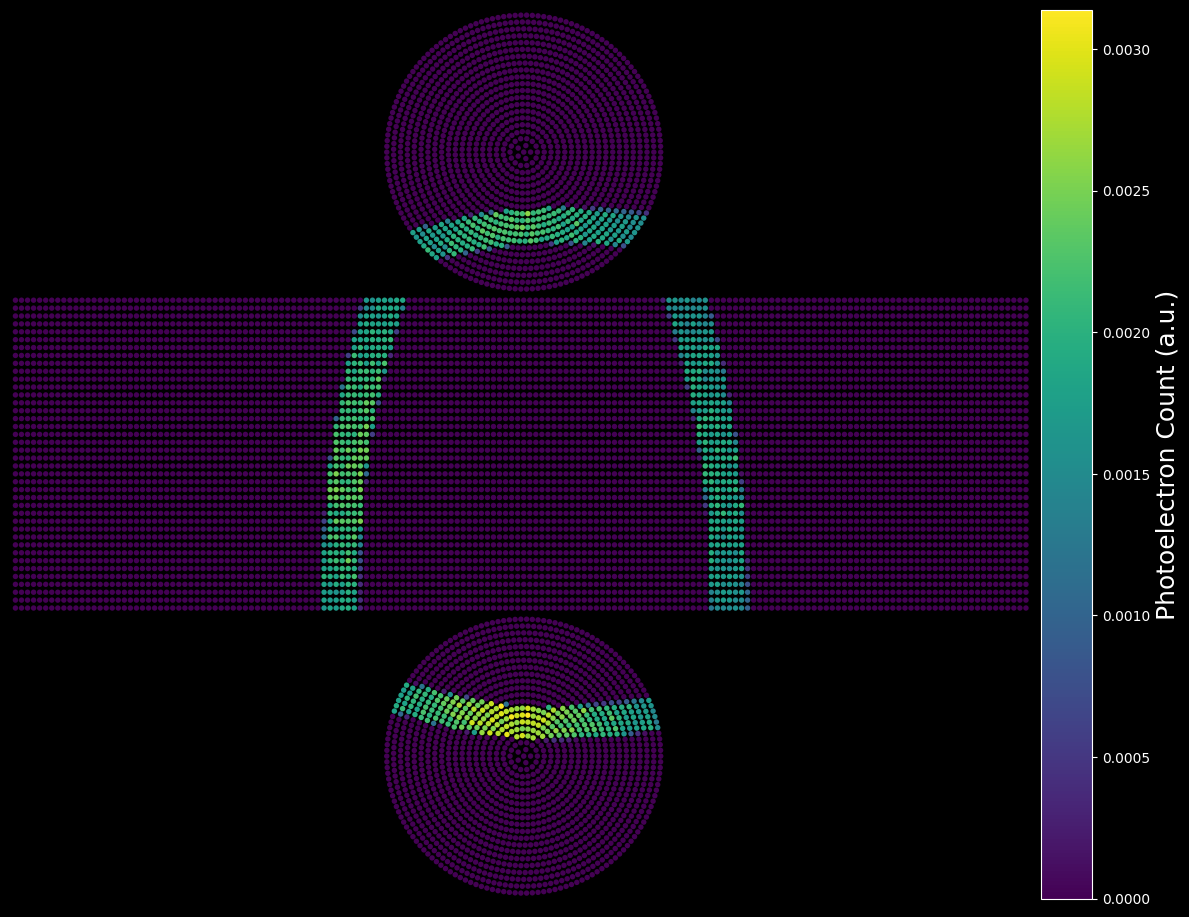

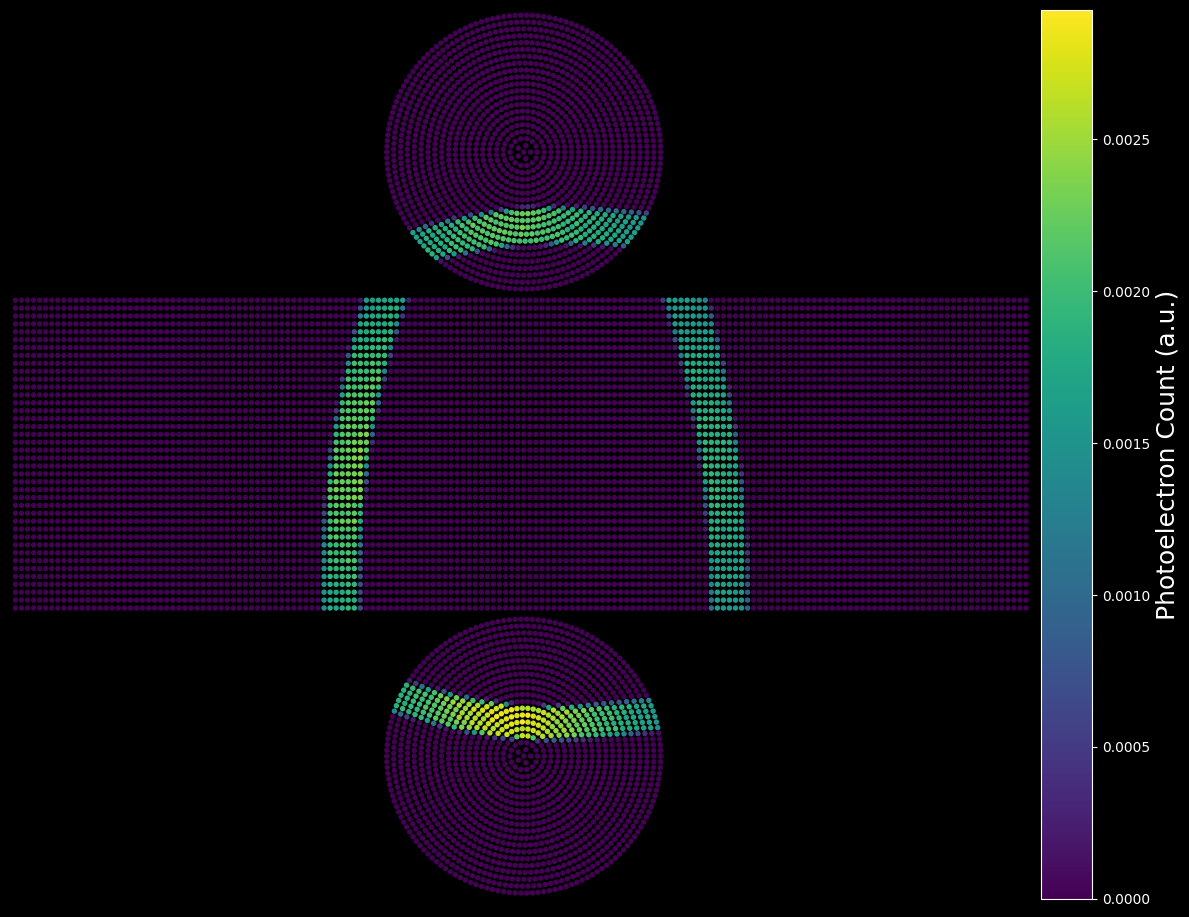

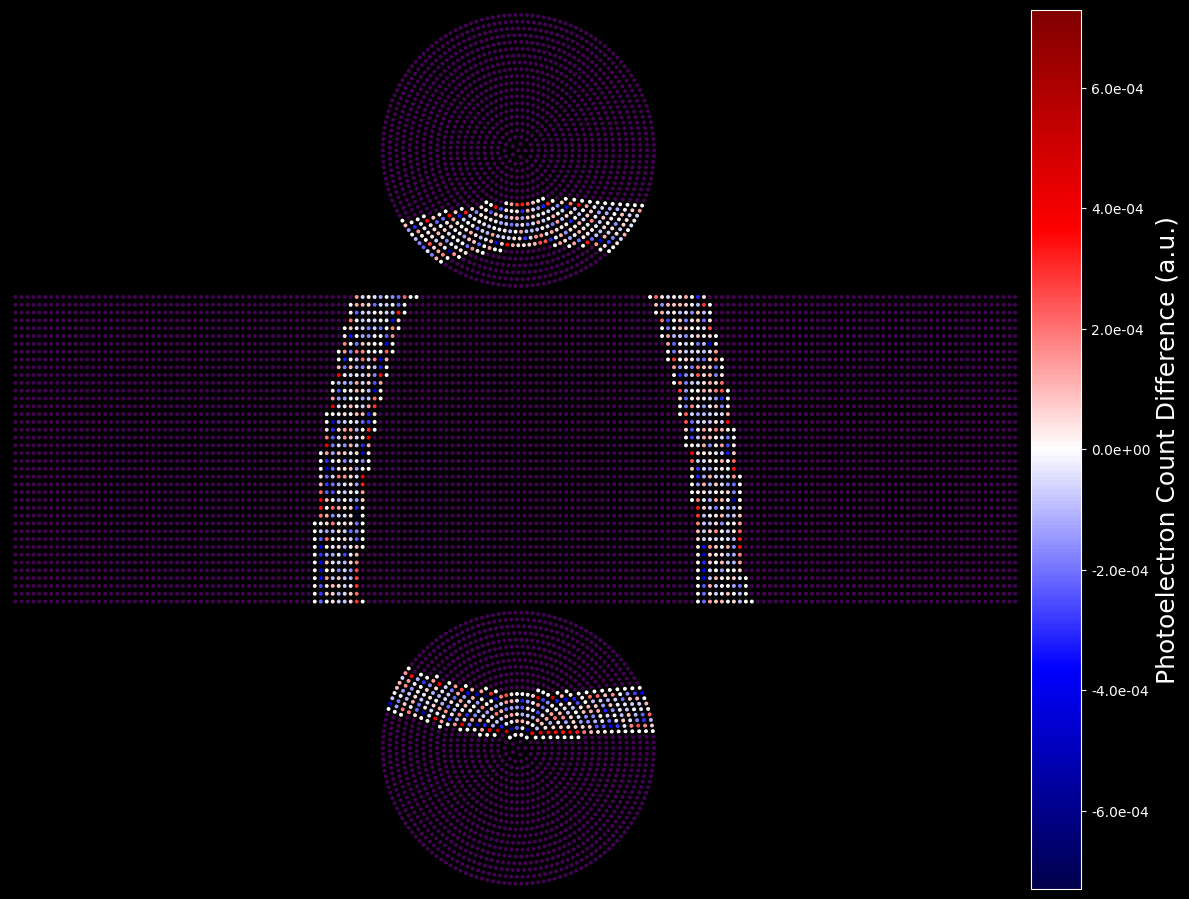

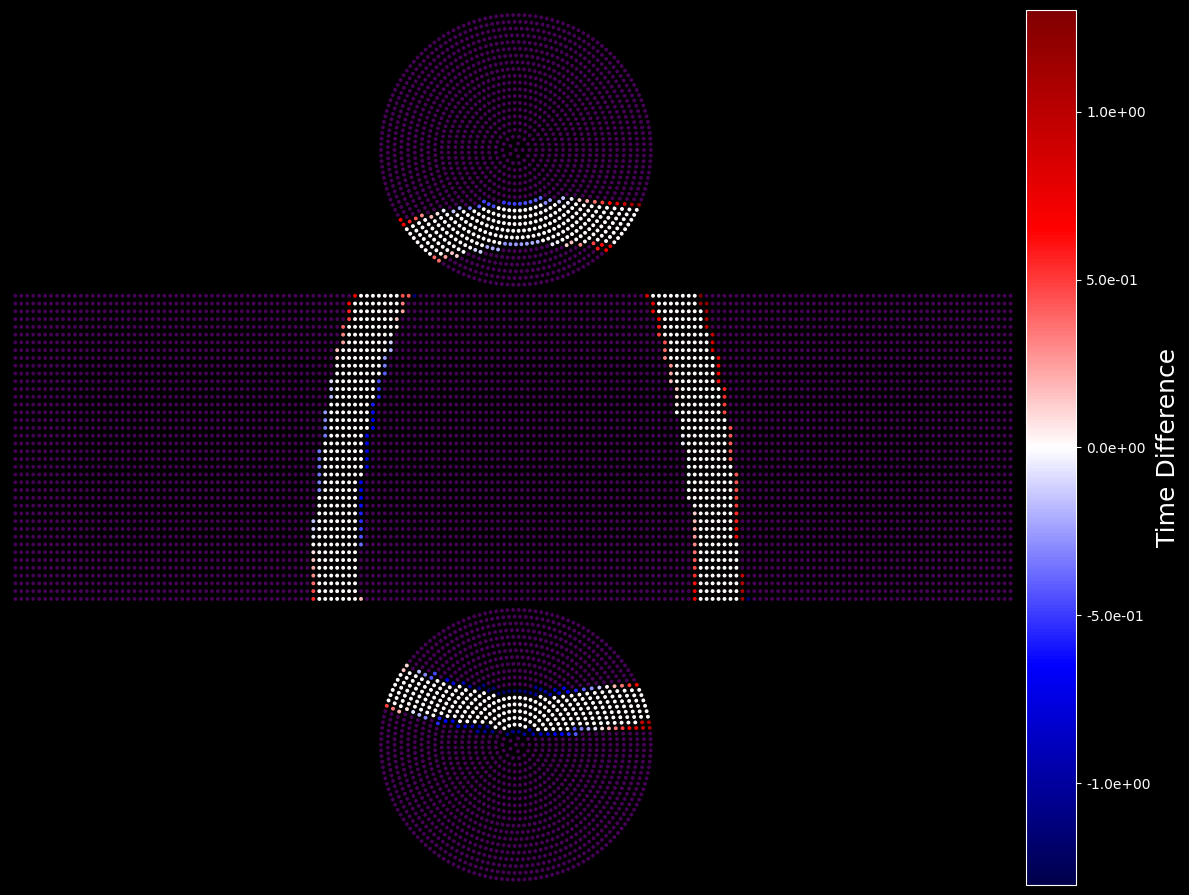

Average charge difference: 0.00010615620703902096
Normalized average charge difference: 0.033820755779743195
Average time difference: -2.2904053764705168e-08
Normalized average time difference: -9.173761306158212e-09


In [13]:
# Evaluate Relaxation Difference

from tools.visualization import create_detector_comparison_display
from tools.utils import sparse_to_full, load_single_event, full_to_sparse

default_json_filename = 'config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 1_000_000

# Generate events with same parameters but different temperatures
key = jax.random.PRNGKey(7109090)

# Use your existing parameter configuration
true_params = generate_random_params(key)

# Generate events
event_data = simulate_true_data(true_params, key)
event_sim = simulate_event(true_params, key)

# Create regular displays for both temperatures
detector_display = create_detector_display(sparse=False)

# Display individual events
detector_display(*event_data, file_name='temp1_display.png', plot_time=False)
detector_display(*event_sim, file_name='temp2_display.png', plot_time=False)

# Create comparison display
detector_comparison = create_detector_comparison_display(sparse=False)

# Display differences with time alignment
detector_comparison(event_data, event_sim, file_name='temp_comparison_charge.png', plot_time=False)
detector_comparison(event_data, event_sim, file_name='temp_comparison_time.png', plot_time=True, align_time=True)

indices1, charges1, times1 = full_to_sparse(*event_data)
indices2, charges2, times2 = full_to_sparse(*event_sim)

# If you want to calculate averages of differences
charges_full1 = sparse_to_full(indices1, charges1, NUM_DETECTORS)
charges_full2 = sparse_to_full(indices2, charges2, NUM_DETECTORS)
charge_diff = charges_full2 - charges_full1
charge_diff_avg = jnp.mean(jnp.abs(charge_diff[charge_diff != 0]))

# Calculate time differences with alignment
times_full1 = sparse_to_full(indices1, times1, NUM_DETECTORS)
times_full2 = sparse_to_full(indices2, times2, NUM_DETECTORS)
active_times1 = times_full1 > 0
active_times2 = times_full2 > 0
times1_mean = jnp.mean(times_full1[active_times1])
times2_mean = jnp.mean(times_full2[active_times2])
times_aligned1 = jnp.where(active_times1, times_full1 - times1_mean, 0)
times_aligned2 = jnp.where(active_times2, times_full2 - times2_mean, 0)
time_diff = times_aligned2 - times_aligned1
time_diff_avg = jnp.mean(time_diff[time_diff != 0])

print(f'Average charge difference: {charge_diff_avg}')
print(f"Normalized average charge difference: {charge_diff_avg/jnp.max(charges_full1)}")
print(f'Average time difference: {time_diff_avg}')
print(f'Normalized average time difference: {time_diff_avg/jnp.max(times_full1)}')

In [1]:
from tools.losses import compute_loss_with_time

[-0.04076528 -0.05060498 -0.08827185 -0.12087202 -0.14372998 -0.14406362
 -0.14096497 -0.0962691  -0.07516929 -0.04855524 -0.07355912 -0.10953697
 -0.11005634 -0.08927716 -0.10911904 -0.11586743 -0.11350784 -0.10632474
 -0.10295822 -0.10238396 -0.09018221 -0.08634134 -0.101425   -0.10788885
 -0.11155919 -0.11605032 -0.10966773 -0.09386947 -0.09549359 -0.10430249
 -0.11075637 -0.11510733 -0.10501555 -0.09985402 -0.0952177  -0.09896846
 -0.10072014 -0.10988884 -0.10797346 -0.09532141 -0.0911966  -0.09427194
 -0.10078961 -0.11170639 -0.12091774 -0.11447458 -0.10312261 -0.09746157
 -0.08783821 -0.07623585 -0.06896702 -0.06813531 -0.07058253 -0.06989297
 -0.06967517 -0.07989883 -0.09698772 -0.11165538 -0.12509137 -0.11560303
 -0.01800577  0.07242291  0.0774397   0.06600261  0.04835989  0.03582702
  0.02561354  0.02340764  0.01981894  0.02263309  0.02808142  0.0344204
  0.0373206   0.04131135  0.05041765  0.05691173  0.05996786  0.0575315
  0.05149295  0.0469933   0.043952    0.04305684  0.0

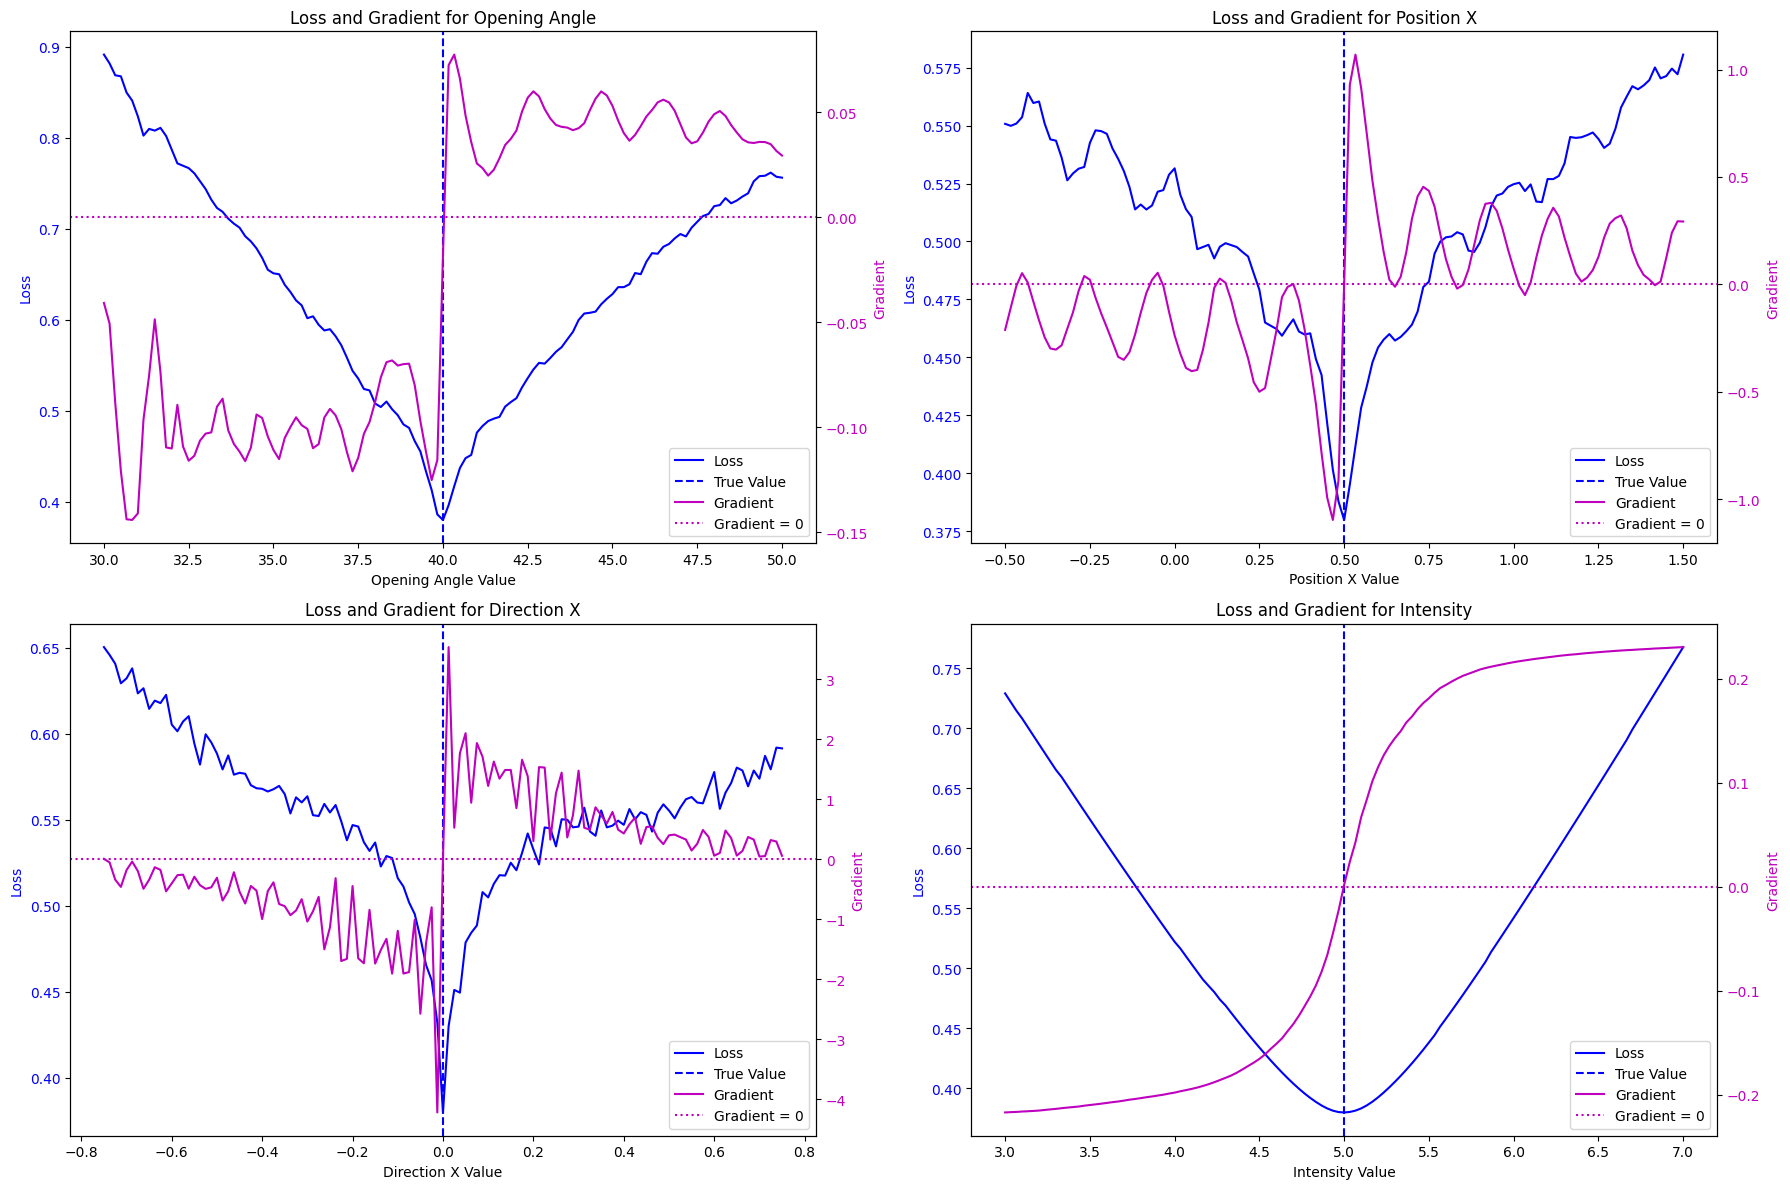

In [31]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt

# True parameters
true_params = (
    jnp.array(40.0),  # opening angle
    jnp.array([0.5, 0.0, 1.0]),  # position
    jnp.array([0.0, 1.0, 0.0]),  # direction
    jnp.array(5.0)  # intensity
)

# Parameter changes
param_changes = (
    jnp.array(10.0),  # opening angle
    jnp.array([1.0, 0.0, 0.0]),  # position (only changing first component)
    jnp.array([0.75, 0.0, 0.0]),  # direction (only changing first component)
    jnp.array(2.0)  # intensity
)

# Generate true data (without gradients)
key = jax.random.PRNGKey(0)

# save to make sure no data leakage
true_data_temp = jax.lax.stop_gradient(simulate_true_data(true_params, key))

# save data
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')

# load data, first element is true_params
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

simulate_event = setup_event_simulator(default_json_filename, Nphot, temperature_sim)

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

@jit
def loss_and_grad(params):
    def loss_fn(params):
        simulated_data = simulate_event(params, key)
        return compute_loss_with_time(detector_points, *true_data, *simulated_data)
    return value_and_grad(loss_fn)(params)

def generate_plot_data(param_index, param_values):
    losses = []
    gradients = []

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value
            
        new_params = tuple(new_params)

        loss, grad = loss_and_grad(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 121
param_ranges = generate_param_ranges(true_params, param_changes, num_points)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

for i, (row, col) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    param_values = param_ranges[i]
    losses, gradients = generate_plot_data(i, param_values)

    print(gradients)
    
    ax1 = axs[row, col]
    ax2 = ax1.twinx()
    
    ax1.plot(param_values, losses, 'b-', label='Loss')
    ax2.plot(param_values, gradients, 'm-', label='Gradient')
    
    # Add vertical line at the center (true parameter value)
    true_value = true_params[i] if i not in [1, 2] else true_params[i][0]
    ax1.axvline(x=true_value, color='b', linestyle='--', label='True Value')
    
    # Add horizontal line for gradient at zero
    ax2.axhline(y=0, color='m', linestyle=':', label='Gradient = 0')
    
    ax1.set_xlabel(f'{param_names[i]} Value')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Gradient', color='m')
    
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='m')
    
    ax1.set_title(f'Loss and Gradient for {param_names[i]}')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()

Generated true parameters:
Event Parameters:
────────────────────
Opening Angle: 72.56 degrees
Initial Position: (-0.09, 0.82, 0.10)
Initial Direction: (0.66, -0.58, -1.07)
Initial Intensity: 7.70
────────────────────


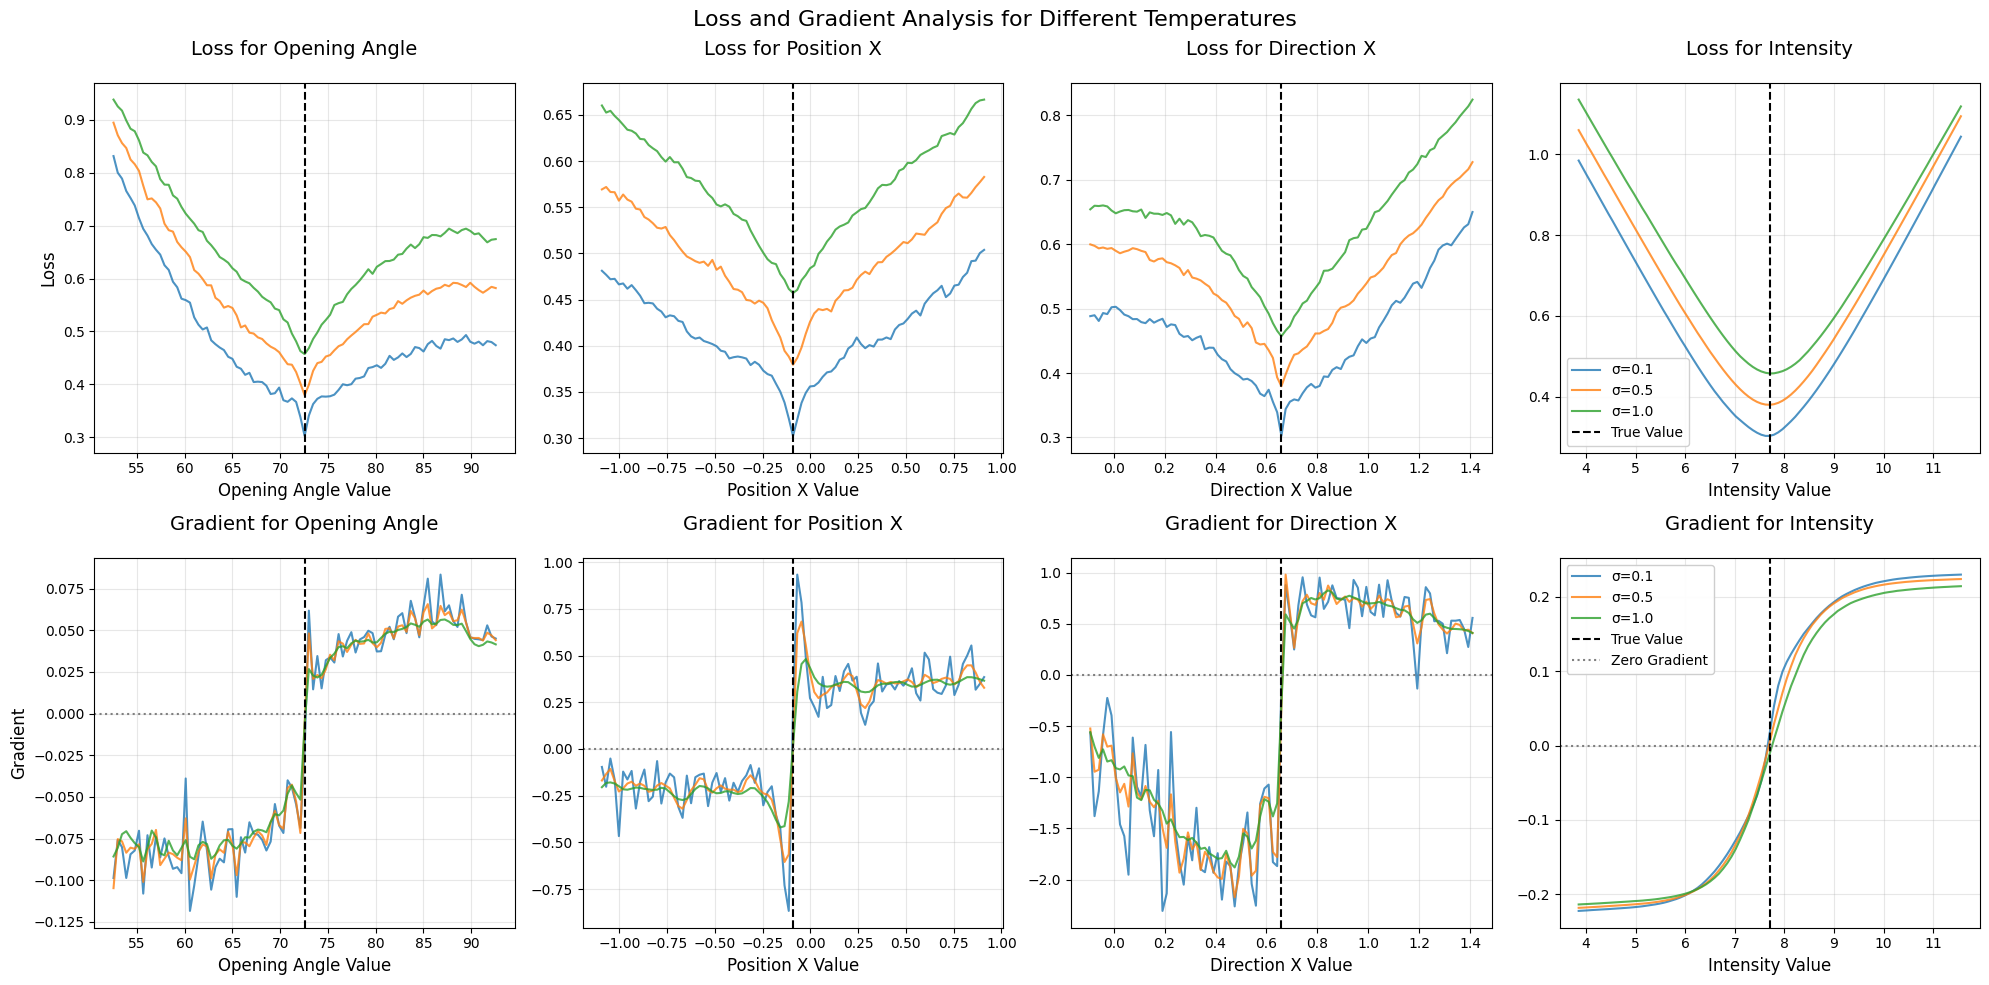

In [38]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss
from tools.simulation import setup_event_simulator

# Define temperatures
temperatures = [0.1, 0.5, 1.0]
Nphot = 1_000_000

# Load detector configuration
default_json_filename = 'config/cyl_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)

# Set up simulators for each temperature
simulators = {
    temp: setup_event_simulator(default_json_filename, Nphot, temp)
    for temp in temperatures
}

# Generate random true parameters
key = jax.random.PRNGKey(90776089000)
key, subkey = jax.random.split(key)
true_params = generate_random_params(subkey)

# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(20.0),  # opening angle (degrees)
    jnp.array([1.0, 0.0, 0.0]),  # position
    jnp.array([0.75, 0.0, 0.0]),  # direction
    true_params[3] * 0.5  # intensity (50% of true value)
)

print("Generated true parameters:")
print_params(true_params)

# Generate true data
true_data_temp = jax.lax.stop_gradient(simulate_true_data(true_params, key))
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

def create_loss_and_grad_fn(simulator):
    @jit
    def loss_and_grad_fn(params):
        def loss_fn(p):
            simulated_data = simulator(p, key)
            return compute_loss_with_time(detector_points, *true_data, *simulated_data)
        return value_and_grad(loss_fn)(params)
    return loss_and_grad_fn

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator):
    losses = []
    gradients = []
    
    loss_and_grad_fn = create_loss_and_grad_fn(simulator)

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value
            
        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 91
param_ranges = generate_param_ranges(true_params, param_changes, num_points)
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

# Create color scheme for different temperatures
colors = list(mcolors.TABLEAU_COLORS.values())[:len(temperatures)]

# Create plots with new layout
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# First row for losses, second row for gradients
for param_idx, param_name in enumerate(param_names):
    param_values = param_ranges[param_idx]
    true_value = true_params[param_idx] if param_idx not in [1, 2] else true_params[param_idx][0]
    
    # Loss plot (top row)
    ax_loss = axs[0, param_idx]
    # Gradient plot (bottom row)
    ax_grad = axs[1, param_idx]
    
    for temp_idx, temp in enumerate(temperatures):
        losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp])
        
        label = f'σ={temp}'
        color = colors[temp_idx]
        
        # Plot loss
        ax_loss.plot(param_values, losses, label=label, color=color, alpha=0.8)
        
        # Plot gradient
        ax_grad.plot(param_values, gradients, label=label, color=color, alpha=0.8)

    # Configure loss plot
    ax_loss.axvline(x=true_value, color='black', linestyle='--', label='True Value')
    ax_loss.set_title(f'Loss for {param_name}', pad=20, fontsize=14)
    ax_loss.set_xlabel(f'{param_name} Value', fontsize=12)
    if param_idx == 0:  # Only add y-label for leftmost plots
        ax_loss.set_ylabel('Loss', fontsize=12)
    if param_idx == len(param_names) - 1:  # Only add legend for rightmost plots
        ax_loss.legend(loc='best', framealpha=0.9)
    ax_loss.grid(True, alpha=0.3)
    
    # Configure gradient plot
    ax_grad.axvline(x=true_value, color='black', linestyle='--', label='True Value')
    ax_grad.axhline(y=0, color='gray', linestyle=':', label='Zero Gradient')
    ax_grad.set_title(f'Gradient for {param_name}', pad=20, fontsize=14)
    ax_grad.set_xlabel(f'{param_name} Value', fontsize=12)
    if param_idx == 0:  # Only add y-label for leftmost plots
        ax_grad.set_ylabel('Gradient', fontsize=12)
    if param_idx == len(param_names) - 1:  # Only add legend for rightmost plots
        ax_grad.legend(loc='best', framealpha=0.95)
    ax_grad.grid(True, alpha=0.3)

plt.suptitle('Loss and Gradient Analysis for Different Temperatures', fontsize=16)
plt.tight_layout()
plt.savefig('temperature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Generated true parameters:
Event Parameters:
────────────────────
Opening Angle: 65.18 degrees
Initial Position: (-0.42, 0.27, 0.87)
Initial Direction: (-0.44, -0.57, 0.31)
Initial Intensity: 2.70
────────────────────


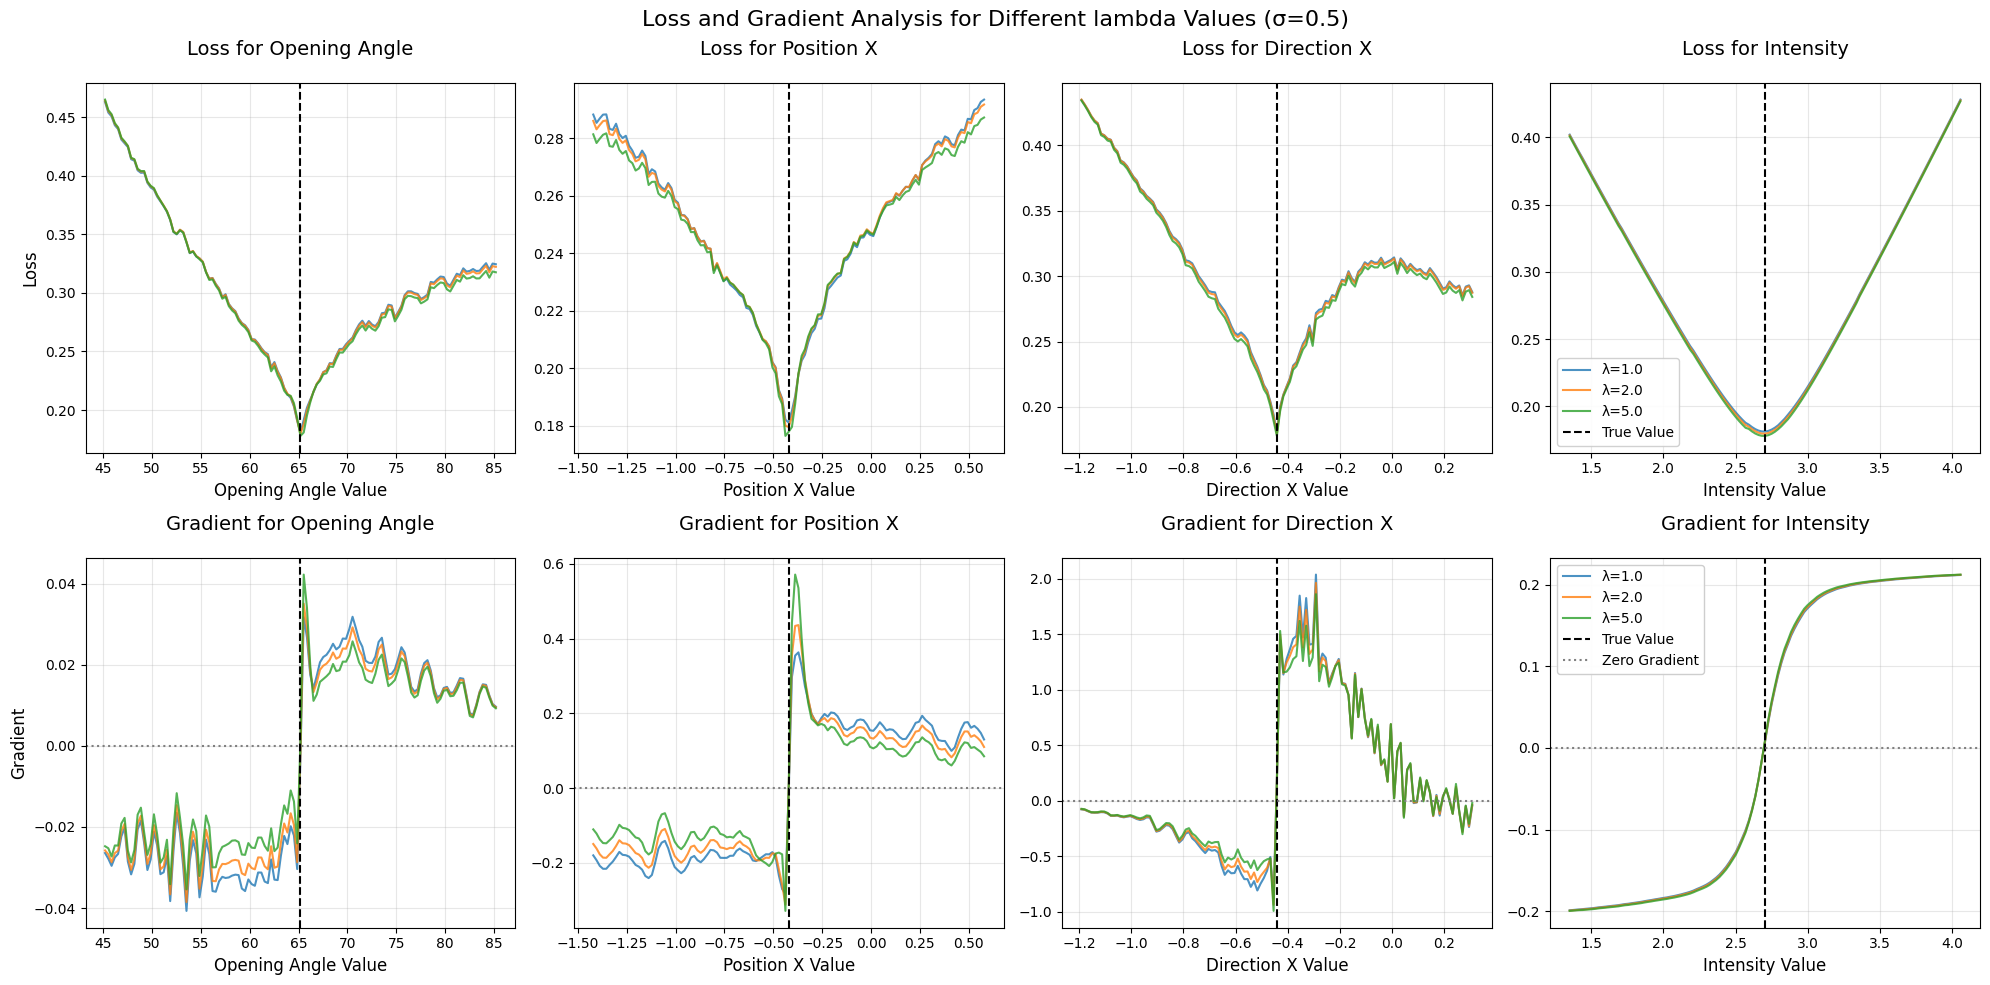

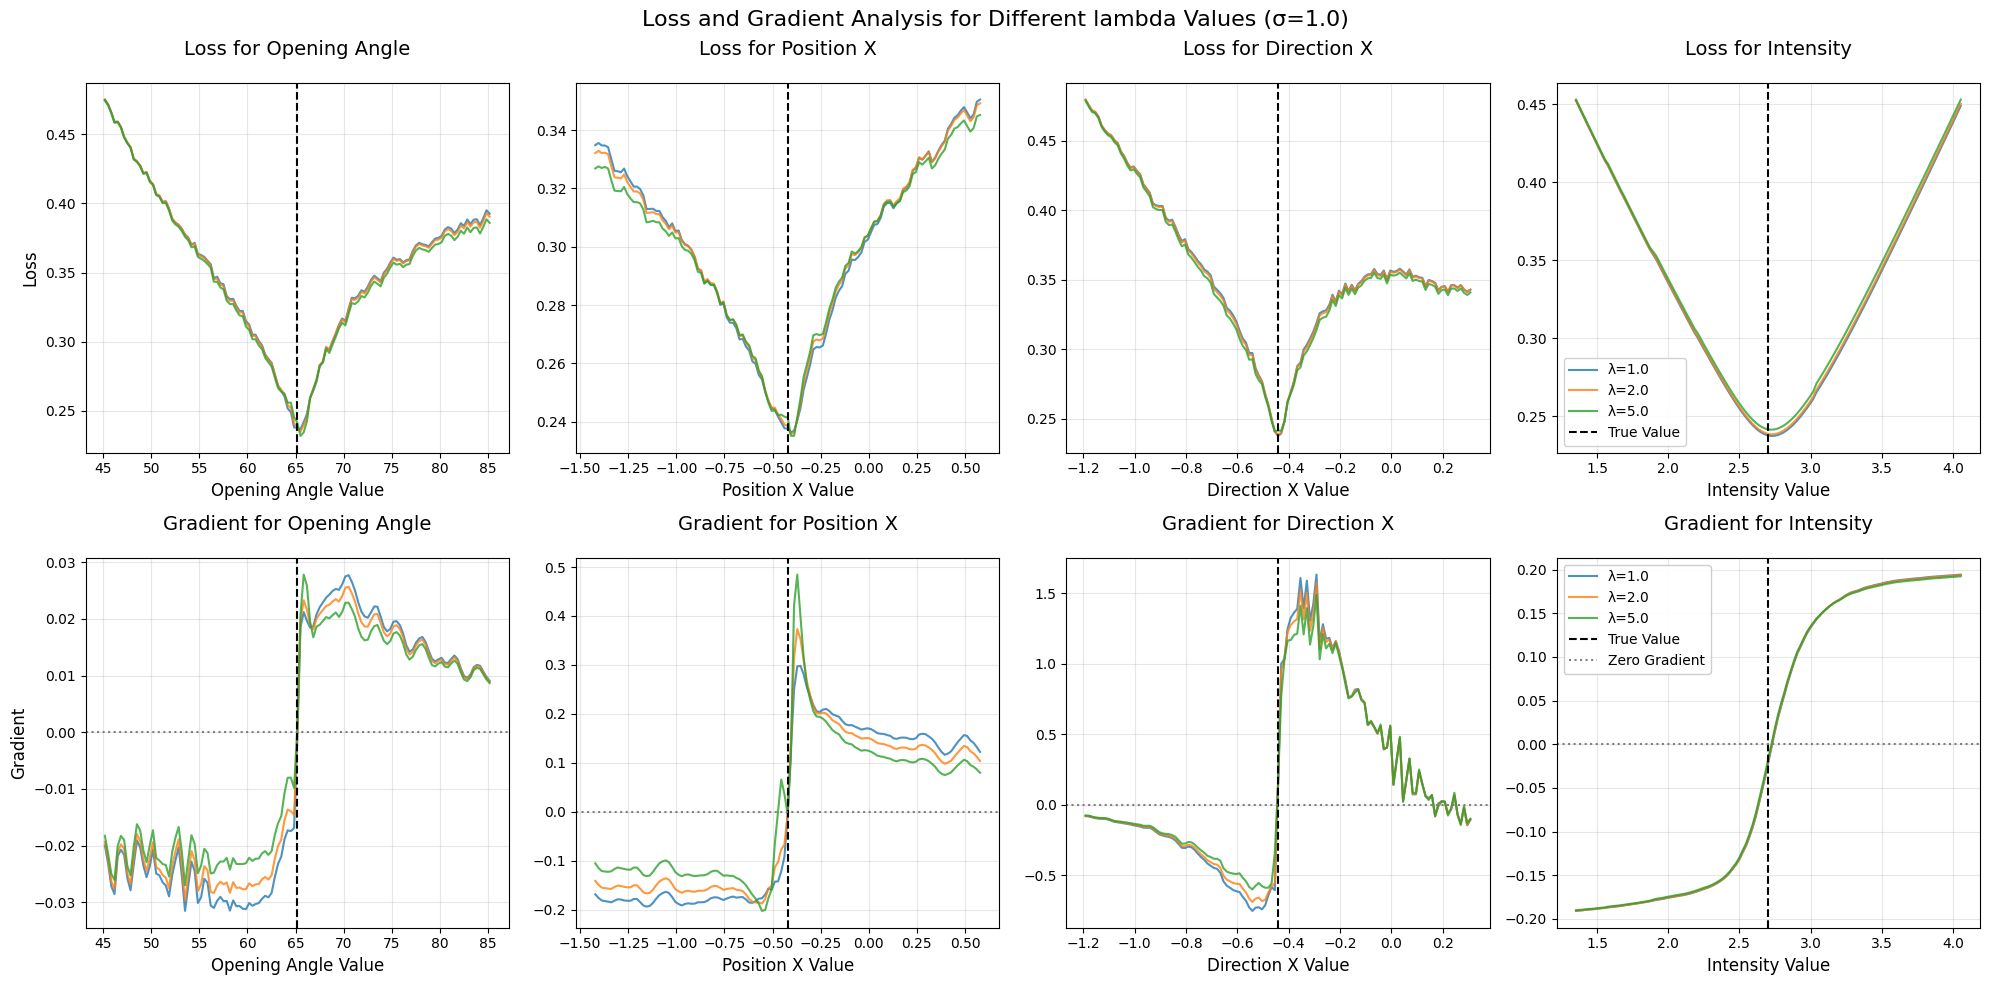

In [91]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss
from tools.simulation import setup_event_simulator

# Define temperatures and tau values
temperatures = [0.5, 1.0]
lambda_times = [1.0, 2.0, 5.0]
Nphot = 1_000_000

# Load detector configuration
default_json_filename = 'config/cyl_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)

# Set up simulators for each temperature
simulators = {
    temp: setup_event_simulator(default_json_filename, Nphot, temp)
    for temp in temperatures
}

# Generate random true parameters
key = jax.random.PRNGKey(90)
key, subkey = jax.random.split(key)
true_params = generate_random_params(subkey)

# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(20.0),  # opening angle (degrees)
    jnp.array([1.0, 0.0, 0.0]),  # position
    jnp.array([0.75, 0.0, 0.0]),  # direction
    true_params[3] * 0.5  # intensity (50% of true value)
)

print("Generated true parameters:")
print_params(true_params)

# Generate true data
true_data_temp = jax.lax.stop_gradient(simulate_true_data(true_params, key))
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

def create_loss_and_grad_fn(simulator, lambda_time):
    @jit
    def loss_and_grad_fn(params):
        def loss_fn(p):
            simulated_data = simulator(p, key)
            return compute_loss_with_time(detector_points, *true_data, *simulated_data, lambda_time=lambda_time)
        return value_and_grad(loss_fn)(params)
    return loss_and_grad_fn

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator, lambda_time):
    losses = []
    gradients = []

    loss_and_grad_fn = create_loss_and_grad_fn(simulator, lambda_time)

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value

        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 121
param_ranges = generate_param_ranges(true_params, param_changes, num_points)
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

# Create color scheme for different lambda values
colors = list(mcolors.TABLEAU_COLORS.values())[:len(lambda_times)]

# Create plots for each temperature
for temp in temperatures:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        param_values = param_ranges[param_idx]
        true_value = true_params[param_idx] if param_idx not in [1, 2] else true_params[param_idx][0]

        # Loss plot (top row)
        ax_loss = axs[0, param_idx]
        # Gradient plot (bottom row)
        ax_grad = axs[1, param_idx]

        for lambda_idx, lambda_time in enumerate(lambda_times):
            losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp], lambda_time=lambda_time)

            label = f'λ={lambda_time}'
            color = colors[lambda_idx]

            # Plot loss
            ax_loss.plot(param_values, losses, label=label, color=color, alpha=0.8)

            # Plot gradient
            ax_grad.plot(param_values, gradients, label=label, color=color, alpha=0.8)

        # Configure loss plot
        ax_loss.axvline(x=true_value, color='black', linestyle='--', label='True Value')
        ax_loss.set_title(f'Loss for {param_name}', pad=20, fontsize=14)
        ax_loss.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:  # Only add y-label for leftmost plots
            ax_loss.set_ylabel('Loss', fontsize=12)
        if param_idx == len(param_names) - 1:  # Only add legend for rightmost plots
            ax_loss.legend(loc='best', framealpha=0.9)
        ax_loss.grid(True, alpha=0.3)

        # Configure gradient plot
        ax_grad.axvline(x=true_value, color='black', linestyle='--', label='True Value')
        ax_grad.axhline(y=0, color='gray', linestyle=':', label='Zero Gradient')
        ax_grad.set_title(f'Gradient for {param_name}', pad=20, fontsize=14)
        ax_grad.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:  # Only add y-label for leftmost plots
            ax_grad.set_ylabel('Gradient', fontsize=12)
        if param_idx == len(param_names) - 1:  # Only add legend for rightmost plots
            ax_grad.legend(loc='best', framealpha=0.95)
        ax_grad.grid(True, alpha=0.3)

    plt.suptitle(f'Loss and Gradient Analysis for Different lambda Values (σ={temp})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'temperature_analysis_temp_{temp}.png', dpi=300, bbox_inches='tight')
    # plt.close()

Generated true parameters:
Event Parameters:
────────────────────
Opening Angle: 65.18 degrees
Initial Position: (-0.42, 0.27, 0.87)
Initial Direction: (-0.44, -0.57, 0.31)
Initial Intensity: 2.70
────────────────────


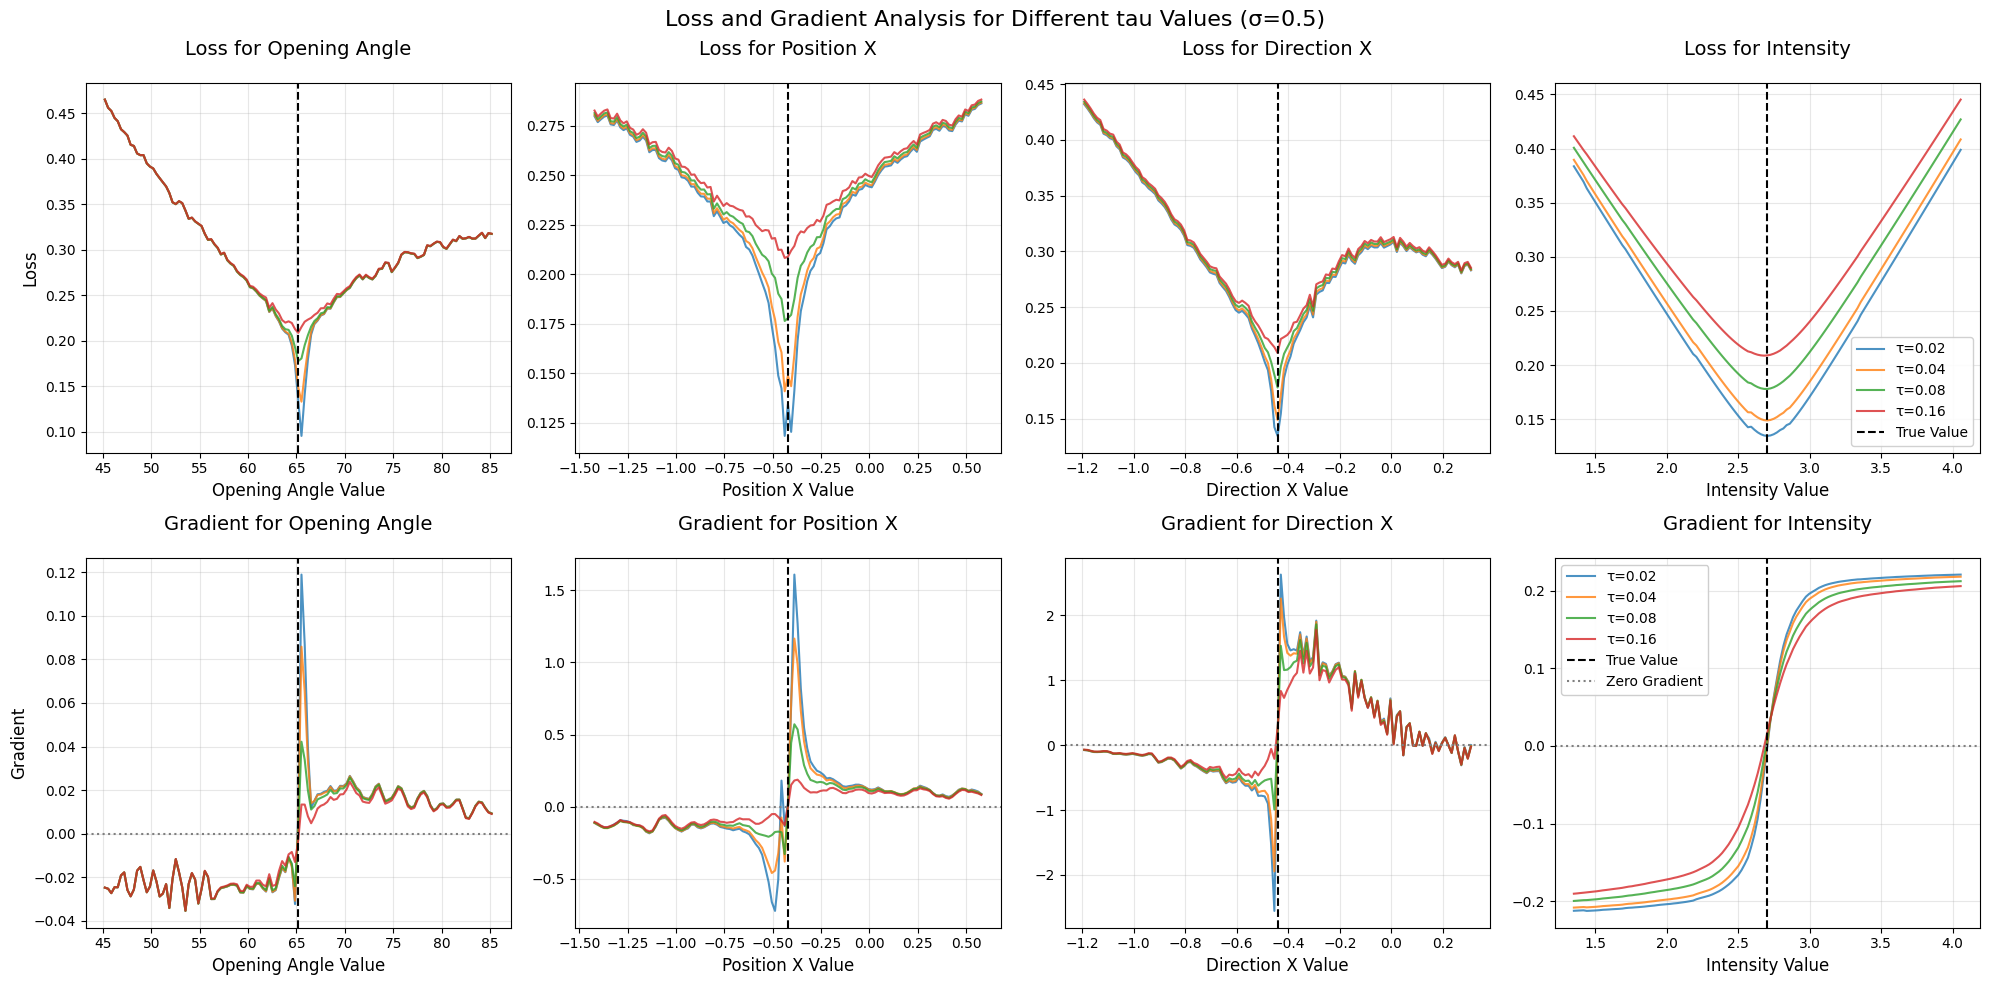

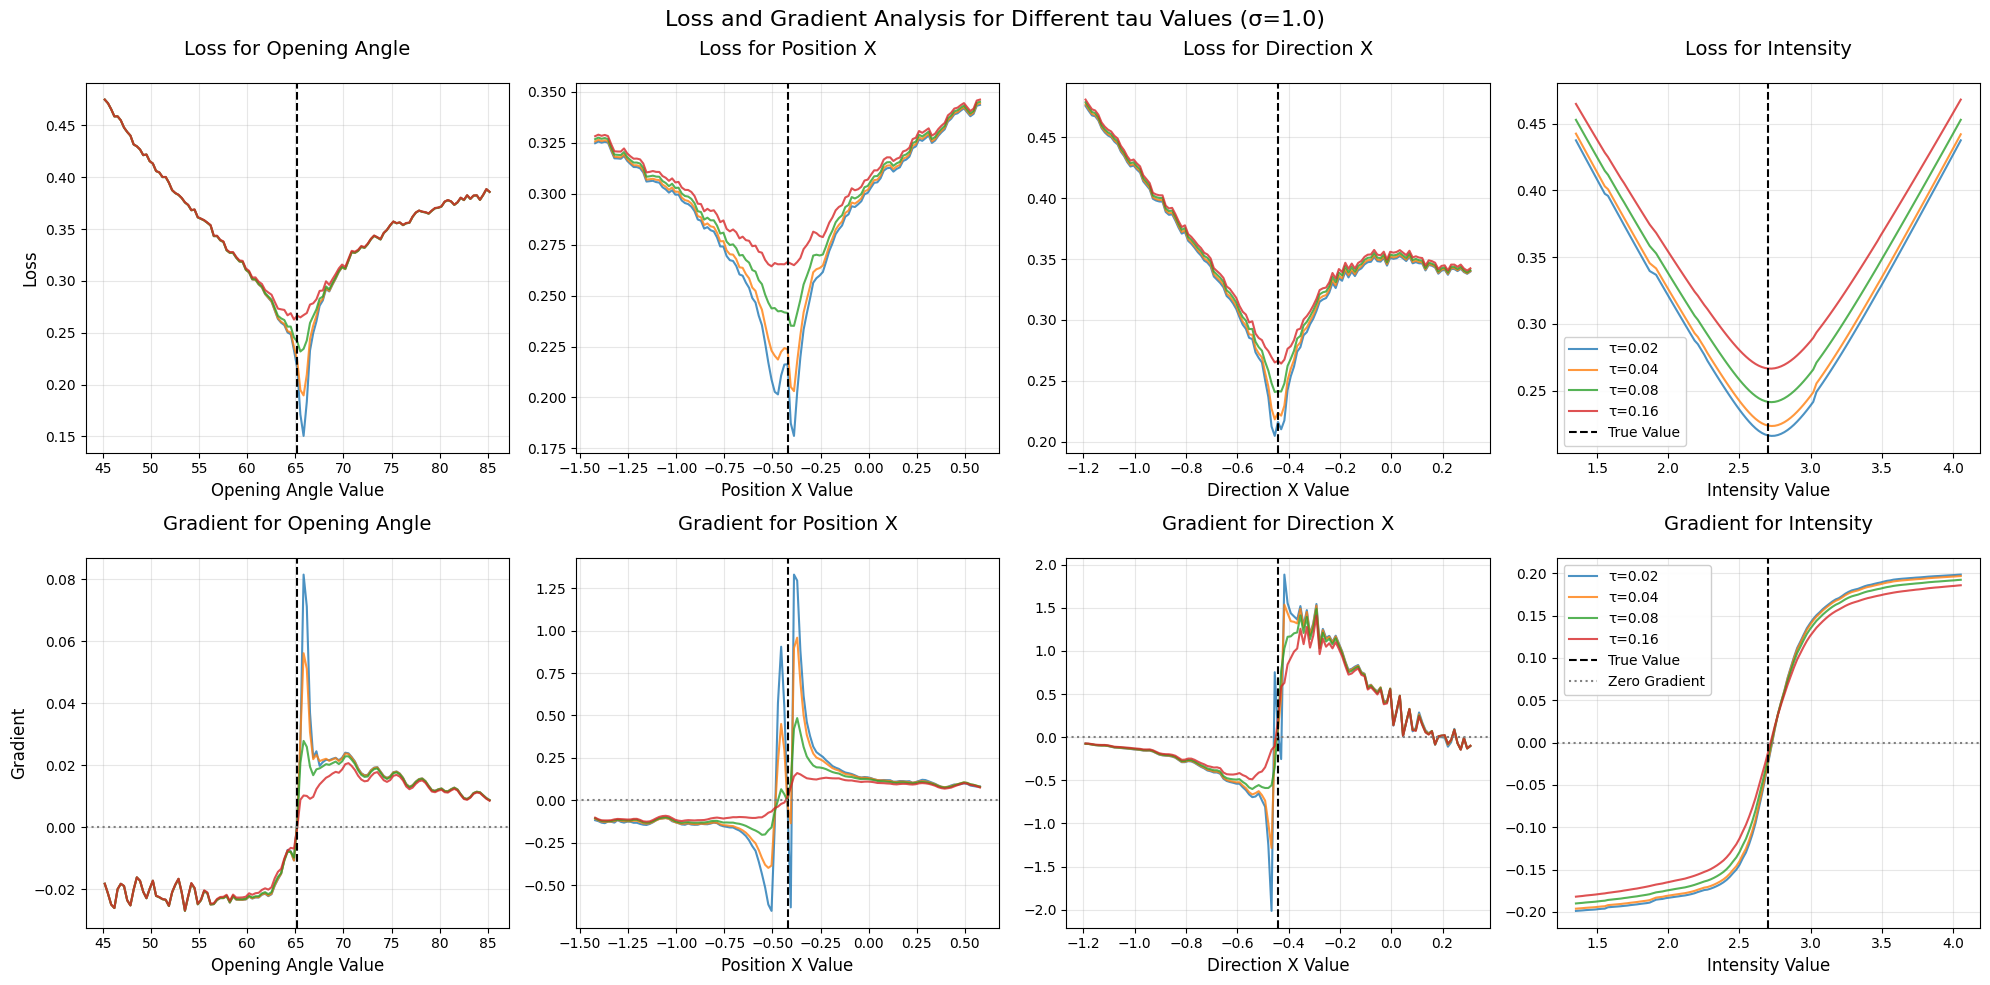

In [90]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss
from tools.simulation import setup_event_simulator

# Define temperatures and tau values
temperatures = [0.5, 1.0]
tau_times = [detector_radius/2, detector_radius, detector_radius*2, detector_radius*4]
Nphot = 1_000_000

# Load detector configuration
default_json_filename = 'config/cyl_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)

# Set up simulators for each temperature
simulators = {
    temp: setup_event_simulator(default_json_filename, Nphot, temp)
    for temp in temperatures
}

# Generate random true parameters
key = jax.random.PRNGKey(90)
key, subkey = jax.random.split(key)
true_params = generate_random_params(subkey)

# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(20.0),  # opening angle (degrees)
    jnp.array([1.0, 0.0, 0.0]),  # position
    jnp.array([0.75, 0.0, 0.0]),  # direction
    true_params[3] * 0.5  # intensity (50% of true value)
)

print("Generated true parameters:")
print_params(true_params)

# Generate true data
true_data_temp = jax.lax.stop_gradient(simulate_true_data(true_params, key))
save_single_event(true_data_temp, true_params, filename='events/true_event_data.h5')
true_data = load_single_event('events/true_event_data.h5', NUM_DETECTORS, sparse=False)[1:]

def create_loss_and_grad_fn(simulator, tau_time):
    @jit
    def loss_and_grad_fn(params):
        def loss_fn(p):
            simulated_data = simulator(p, key)
            return compute_loss_with_time(detector_points, *true_data, *simulated_data, tau_time=tau_time, tau_position=tau_time, lambda_time=5.0)
        return value_and_grad(loss_fn)(params)
    return loss_and_grad_fn

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator, tau_time):
    losses = []
    gradients = []

    loss_and_grad_fn = create_loss_and_grad_fn(simulator, tau_time)

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value

        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

# Generate parameter ranges
num_points = 121
param_ranges = generate_param_ranges(true_params, param_changes, num_points)
param_names = ['Opening Angle', 'Position X', 'Direction X', 'Intensity']

# Create color scheme for different tau values
colors = list(mcolors.TABLEAU_COLORS.values())[:len(tau_times)]

# Create plots for each temperature
for temp in temperatures:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        param_values = param_ranges[param_idx]
        true_value = true_params[param_idx] if param_idx not in [1, 2] else true_params[param_idx][0]

        # Loss plot (top row)
        ax_loss = axs[0, param_idx]
        # Gradient plot (bottom row)
        ax_grad = axs[1, param_idx]

        for tau_idx, tau_time in enumerate(tau_times):
            losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp], tau_time=tau_time)

            label = f'τ={tau_time}'
            color = colors[tau_idx]

            # Plot loss
            ax_loss.plot(param_values, losses, label=label, color=color, alpha=0.8)

            # Plot gradient
            ax_grad.plot(param_values, gradients, label=label, color=color, alpha=0.8)

        # Configure loss plot
        ax_loss.axvline(x=true_value, color='black', linestyle='--', label='True Value')
        ax_loss.set_title(f'Loss for {param_name}', pad=20, fontsize=14)
        ax_loss.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:  # Only add y-label for leftmost plots
            ax_loss.set_ylabel('Loss', fontsize=12)
        if param_idx == len(param_names) - 1:  # Only add legend for rightmost plots
            ax_loss.legend(loc='best', framealpha=0.9)
        ax_loss.grid(True, alpha=0.3)

        # Configure gradient plot
        ax_grad.axvline(x=true_value, color='black', linestyle='--', label='True Value')
        ax_grad.axhline(y=0, color='gray', linestyle=':', label='Zero Gradient')
        ax_grad.set_title(f'Gradient for {param_name}', pad=20, fontsize=14)
        ax_grad.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:  # Only add y-label for leftmost plots
            ax_grad.set_ylabel('Gradient', fontsize=12)
        if param_idx == len(param_names) - 1:  # Only add legend for rightmost plots
            ax_grad.legend(loc='best', framealpha=0.95)
        ax_grad.grid(True, alpha=0.3)

    plt.suptitle(f'Loss and Gradient Analysis for Different tau Values (σ={temp})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'temperature_analysis_temp_{temp}.png', dpi=300, bbox_inches='tight')
    # plt.close()